In [3]:
"""
Script to average together images from HipGISAXS-2.0
31.10.2022
Paul Vautravers
"""
#Import relevant libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

In [8]:
#Read in images from path, assign to list, using glob 
#path must be amended!!
images = [cv2.imread(file) for file in glob.glob("hipgisaxs/hipgisaxs-2.0/agnw_2360_imgs/0.4_deg/28.09.22/*.png")]

In [5]:
def blend_images(image_list):
    """
    Function to blend array of images together, averaging pixel values
    Input: List of hipgisaxs images to be averaged
    Outputs: averaged image of images from input list
    """
    #weighting applied to images
    img_weight = 1/(len(image_list))
    output = np.zeros_like(image_list[0])
    
    #images averaged using sum of weighted values
    for img in image_list:
        output = output + img * img_weight

    output = output.astype(np.uint8)
    return output

In [17]:
def array_split(array_in):
    """
    Function to split an array in two
    Input: Initial array to be split
    Output: Returns two halves of split array
    """
    #adjusts array to be even length
    if len(array_in)%2 !=0:
        array_in = array_in[:-1]
    #two halves of initial array are split up
    arr_half_1 = array_in[:len(array_in)//2]
    arr_half_2 = array_in[len(array_in)//2:]
    
    return arr_half_1,arr_half_2

def array_split_recur(array_in):
    """
    Function to cascade through large array and split into groups of 2, 4,8 etc
    Input: Initial array to divided up, must be of length 2**n where n is some integer
    Output: Returns dictionary with splits of initial array into subgroups of decreasing size, labels 
    are the length of subgroup, and index returns which subgroup of that length
    """
    img_shape = np.shape(array_in[0])
    array_dict = {}
    n_div = np.log2(len(array_in))
    #iterates up to max allowed division, n 
    for i in range(int(n_div)):
        #labelled with length of subgroup 
        label_val = int(len(array_in)/(2**(i)))
        #new shape made for each entry in dictionary
        new_shape = (2**(i),label_val,img_shape[0],img_shape[1],img_shape[2])
        array_dict["{}".format(label_val)] = np.reshape(array_in,new_shape)

    return array_dict    

In [19]:
def recur_img_blend(img_arr_dict):
    """
    Function to recursively blend images from a dictionary
    Input: Initial dictionary with entries split into different lengths
    Output: Returns dictionary of blended images, labelled by number of images that were blended together, the index corresponds
    the subgroup of images that contributed to that blend
    """
    img_output_dict = {}
    keys_list = list(img_arr_dict)
    for i,key in enumerate(keys_list):
        #construct empty array for new blended images
        img_shape = np.shape(img_arr_dict[key][0])
        img_arr_size = int(2**(float(i)))
        images = np.empty((img_arr_size,img_shape[1],img_shape[2],img_shape[3]),dtype=int)
        #blend subgroups of images together, iterating over dictionary entry
        for j in range(img_arr_size):
            images[j] = cv2.cvtColor(blend_images(img_arr_dict[key][j]), cv2.COLOR_BGR2RGB)         
        #new dictionary entry with blended images
        img_output_dict[key] = images
        
    return img_output_dict

In [21]:
#array of input images is split into subgroups and made into a dictionary
#length of input image list should always be restricted to a power of 2, e.g. 2, 16 or 256 etc
agnw_img_dict = array_split_recur(images[:256])
#images in divided up dictionary are blended together and stored in new dictionary
agnw_img_avg_dict = recur_img_blend(agnw_img_dict)

(-0.5, 949.5, 950.5, -0.5)

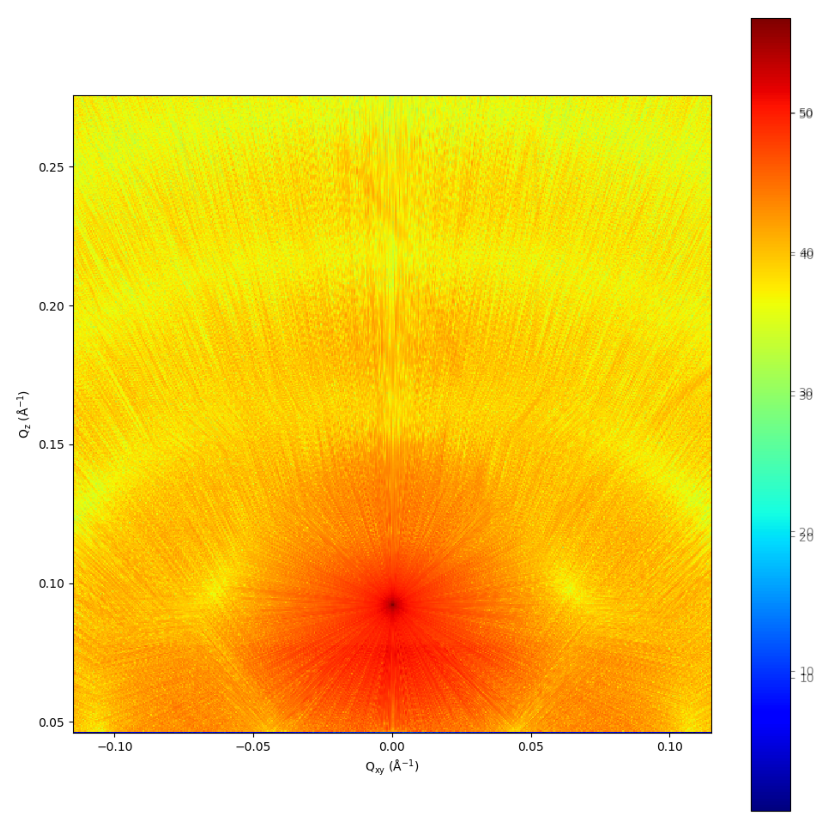

In [22]:
#Example: Average image for a given dictionary entry is shown below
fig,ax = plt.subplots(figsize=(15, 15))
ax.imshow(agnw_img_avg_dict['2'][9])
ax.axis('off')